# Covac Analysis

In [1]:
import datetime
import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib import pyplot as plt

import seaborn as sns
sns.set_theme("paper")
sns.set_style("whitegrid")

In [2]:
import os

DATA_DIR = "/home/ubuntu/data"

corona_ann = sc.read_h5ad(os.path.join(DATA_DIR, "COVAC_POSTQC.h5ad"))

In [10]:
dense_data = corona_ann.X.todense()

In [12]:
dense_data.shape

(491473, 21570)

In [18]:
dense_data.nbytes / 1000 ** 3

42.40429044

In [5]:
corona_ann[corona_ann.obs.cohort == "B"].obs.patientID.unique()

['B12', 'B4', 'B9', 'B6', 'B10', 'B13', 'B3', 'B2', 'B1']
Categories (9, object): ['B1', 'B2', 'B3', 'B4', ..., 'B9', 'B10', 'B12', 'B13']

In [3]:
corona_ann.raw = corona_ann.copy()

## Highest Overall Expressed Genes

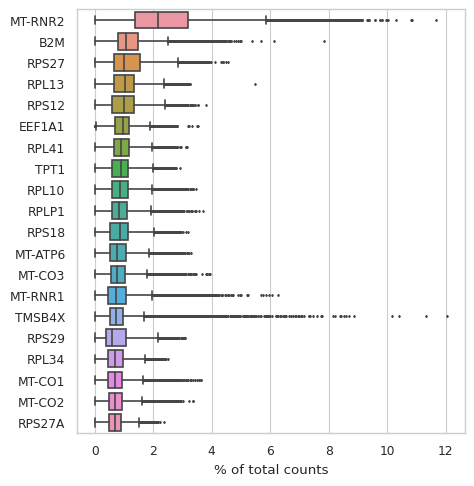

In [11]:
sc.pl.highest_expr_genes(corona_ann, n_top=20, )

## Basic preliminary Filtering

In [6]:
sc.pp.filter_cells(corona_ann, min_genes=200)
sc.pp.filter_genes(corona_ann, min_cells=3)

In [7]:
corona_ann.layers["counts"] = corona_ann.X.copy()

## QC Plots

In [8]:
# annotate the group of mitochondrial genes as 'mt'
corona_ann.var['mito'] = corona_ann.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'

# recalculate the included QC metrics 
_ = sc.pp.calculate_qc_metrics(corona_ann, qc_vars=['mito'], percent_top=None, log1p=False, inplace=True)

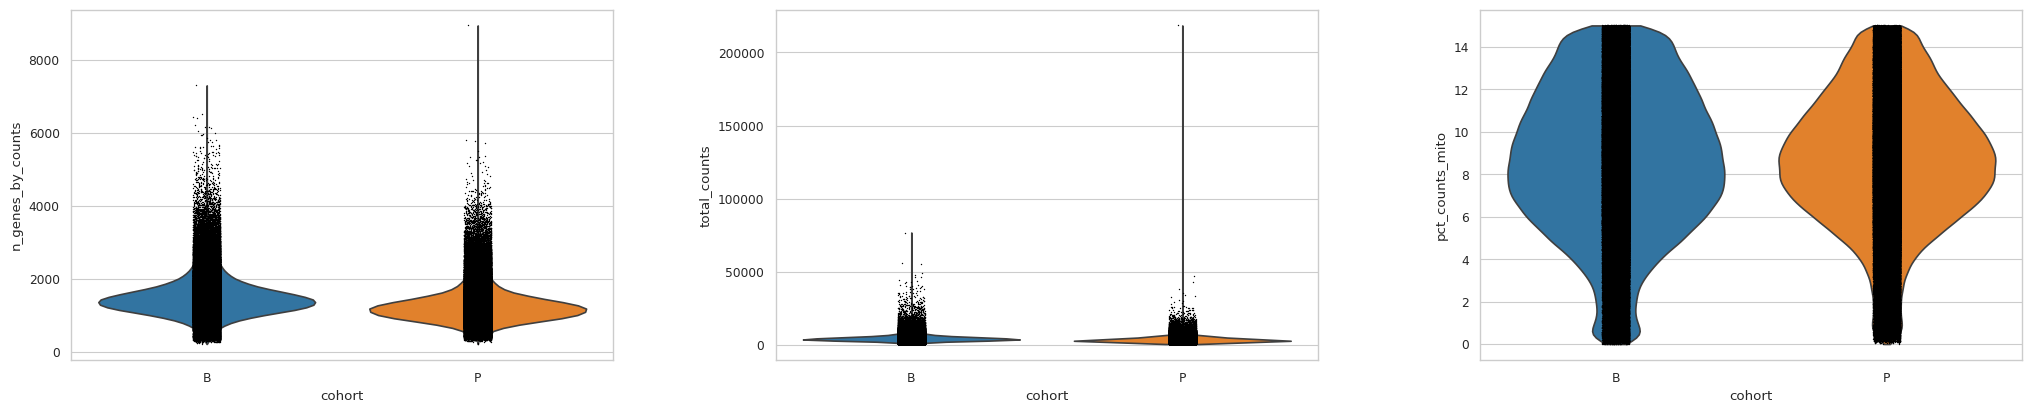

In [12]:
sc.pl.violin(corona_ann, ['n_genes_by_counts', 'total_counts', 'pct_counts_mito'], groupby="cohort", jitter=0.05, multi_panel=True, save=".png")

<Axes: xlabel='total_counts', ylabel='pct_counts_mito'>

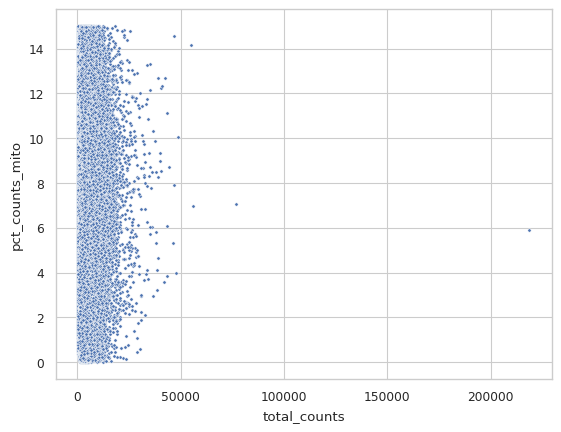

In [13]:
sns.scatterplot(data=corona_ann.obs, x="total_counts", y="pct_counts_mito", marker=".")


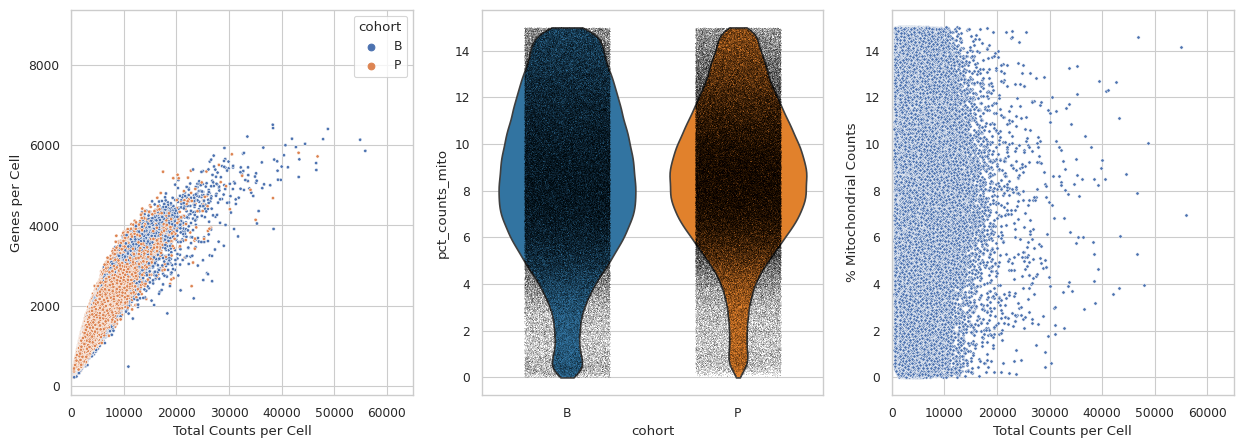

In [18]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(15,5))

sns.scatterplot(data=corona_ann.obs, x="total_counts", y="n_genes_by_counts", hue="cohort", marker=".", ax=ax1)
ax1.set_xlim((0,65000))  # exclude crazy outliers
#ax1.axhline(750, c="red")  # draw roughly what to exclude
#ax1.axvline(1000, c="red")  # draw roughly what to exclude
ax1.set_xlabel("Total Counts per Cell")
ax1.set_ylabel("Genes per Cell")

sns.scatterplot(data=corona_ann.obs, x="total_counts", y="pct_counts_mito", marker=".", ax=ax3)
ax3.set_xlim((0,65000))  # exclude crazy outliers
ax3.set_xlabel("Total Counts per Cell")
ax3.set_ylabel("% Mitochondrial Counts")

sc.pl.violin(corona_ann, ['pct_counts_mito'], groupby="cohort", size=0.2, jitter=0.25, ax=ax2)
ax2.set_xlabel("Cohort")
ax2.set_ylabel("% Mitochondiral Counts")


fig.show()
fig.savefig("figures/qc_plots.png")

Text(0.5, 0, 'Mean Expression per gene')

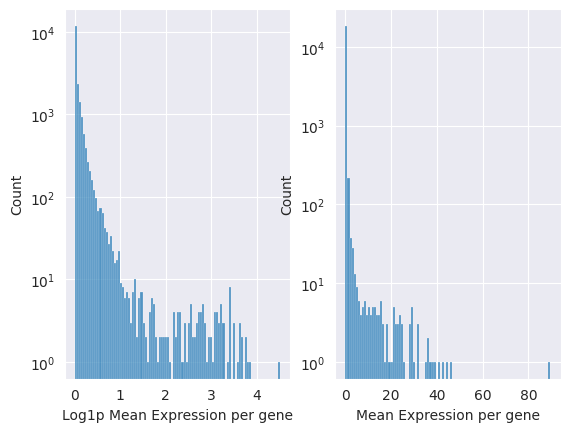

In [11]:
mean_X = np.array(np.mean(corona_ann.X, axis=0)).flatten()

fig, (ax1, ax2) = plt.subplots(1, 2)

sns.histplot(np.log1p(mean_X), bins=100, ax=ax1)
ax1.set_yscale("log")
ax1.set_xlabel("Log1p Mean Expression per gene")

sns.histplot(mean_X, bins=100, ax=ax2)
ax2.set_yscale("log")
ax2.set_xlabel("Mean Expression per gene")

## Preprocessing

In [12]:
# Find Cells That express at least one Erythrocyte Markers
ery_markers = ["HBB", "HBA1", "HBA2"]
idx = np.array((corona_ann[: , ery_markers].X > 0).sum(axis=1)).flatten()
idx = (idx > 0)

# Remove erythrocyte marker expressing genes from data
corona_ann = corona_ann[~idx,:]

print("%s cells removed, expressing at least one of %s" % (sum(idx), ", ".join(ery_markers)))

12903 cells removed, expressing at least one of HBB, HBA1, HBA2


In [13]:
corona_ann.layers["counts"] = corona_ann.X.copy()

In [14]:
# filter cells with high percent of mitochondrial genes (=potentially low quality)  and low number of genes
print("Before:", corona_ann.shape)
corona_ann = corona_ann[corona_ann.obs.n_genes_by_counts < 5000, :]
corona_ann = corona_ann[corona_ann.obs.pct_counts_mito < 12, :]
print("After:", corona_ann.shape)

Before: (478570, 18910)
After: (398598, 18910)


In [15]:
# normalize
sc.pp.normalize_total(corona_ann, inplace=True)

# log transform
sc.pp.log1p(corona_ann)

/home/ubuntu/.local/share/virtualenvs/masterthesis-aGTe3VWb/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [16]:
corona_ann.layers["lognorm_counts"] = corona_ann.X.copy()

### Write out

In [17]:
corona_ann.write_h5ad(os.path.join(DATA_DIR, "COVAC_preprocessed.h5ad"))

# Test UMAPs

In [55]:
import os
DATA_DIR = "/home/ubuntu/data"
corona_ann = sc.read_h5ad(os.path.join(DATA_DIR, "COVAC_preprocessed.h5ad"))

# Fix uns data, which is not being saved for some reason ...
if corona_ann.uns.get("log1p") is not None:
    if (corona_ann.uns["log1p"].get("base") is None):
        print("... fixing .uns['log1p']") 
        corona_ann.uns["log1p"] = {"base": None}

... fixing .uns['log1p']


In [56]:
import scanpy as sc
import scanpy.external as sce

In [57]:
corona_ann.raw = corona_ann

In [58]:
sc.pp.highly_variable_genes(corona_ann, min_mean=0.005, max_mean=3, min_disp=0.5)
print(sum(corona_ann.var.highly_variable))

1456


In [59]:
sc.pp.highly_variable_genes(corona_ann, min_mean=0.0125, max_mean=3, min_disp=0.5)

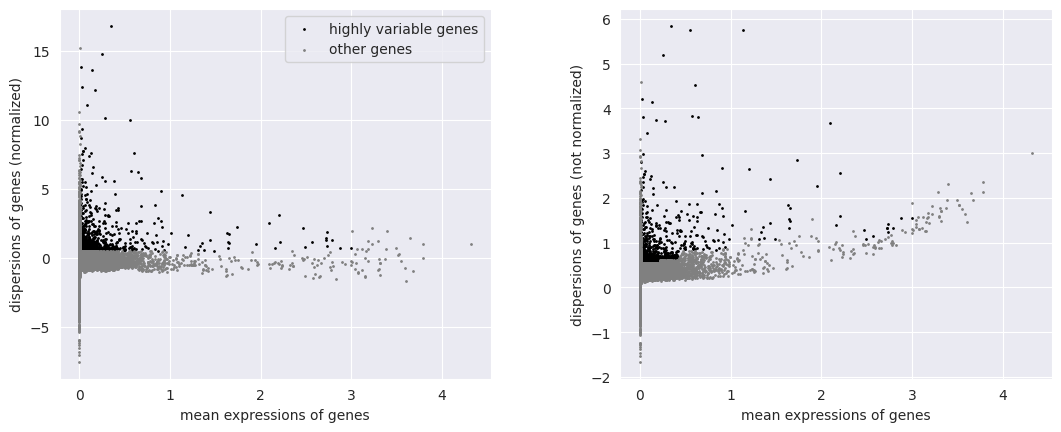

In [60]:
sc.pl.highly_variable_genes(corona_ann)

In [61]:
# reduce to highly variable or pbmc marker
corona_ann = corona_ann[:, corona_ann.var.highly_variable | corona_ann.var_names.isin(pbmc_markers)]

NameError: name 'pbmc_markers' is not defined

In [ ]:
# reduce to lineage markers
#corona_ann = corona_ann[:, corona_ann.var_names.isin(pbmc_markers)]

In [ ]:
# scaling: Scaling will reduce sparsity, but the penalty and fit work better with centered data
sc.pp.scale(corona_ann, zero_center=True, copy=False)

### Inspect Batch effect

In [ ]:
start = datetime.datetime.now()
sc.pp.neighbors(corona_ann)
sc.tl.umap(corona_ann)
corona_ann.obsm["X_umap_raw"] = corona_ann.obsm["X_umap"].copy()
print(datetime.datetime.now() - start)

In [ ]:
sc.pl.umap(corona_ann, components="1,2", color=["cohort", "patientID"])

### Harmony Batch Integration 

Produces a corrected PCA embedding. No correction of counts!

In [ ]:
import scanpy.external as sce
sc.tl.pca(corona_ann)
sce.pp.harmony_integrate(corona_ann, 'patientID')

In [ ]:
start = datetime.datetime.now()
sc.pp.neighbors(corona_ann, use_rep="X_pca_harmony", key_added="neighbors_harmony")
sc.tl.umap(corona_ann, neighbors_key="neighbors_harmony")  # overwrites obsm["X_umap"]
corona_ann.obsm["X_umap_harmony"] = corona_ann.obsm["X_umap"].copy()
print(datetime.datetime.now() - start)

In [ ]:
sc.pl.umap(corona_ann, color=["cohort", "patientID"])

### MMNpy Batch correction

Corrects the counts by matching mutual nearest neighbors

In [ ]:
import scanpy.external as sce
sce.pp.mnn_correct(corona_ann, batch_key="patientID", n_jobs=10)

In [ ]:
start = datetime.datetime.now()
sc.pp.neighbors(corona_ann, use_rep="X", key_added="neighbors_mmnpy")
sc.tl.umap(corona_ann, neighbors_key="neighbors_mmnpy")  # overwrites obsm["X_umap"]
corona_ann.obsm["X_umap_mmnpy"] = corona_ann.obsm["X_umap"].copy()
print(datetime.datetime.now() - start)

In [ ]:
sc.pl.umap(corona_ann, color=["cohort", "patientID"])

In [ ]:
start = datetime.datetime.now()
# Clustering
sc.tl.leiden(corona_ann, resolution=1, neighbors_key="neighbors_harmony")
print(datetime.datetime.now() - start)

In [ ]:
corona_ann.obsm["X_umap"] = corona_ann.obsm["X_umap_harmony"]
sc.pl.umap(corona_ann, color=["leiden", "cohort", "patientID", "timepoint"], ncols=2)

In [ ]:
sc.tl.rank_genes_groups(corona_ann, "leiden", method="wilcoxon")

In [ ]:
sc.pl.rank_genes_groups(corona_ann, n_genes=35, sharey=False)

In [ ]:
#sc.pl.rank_genes_groups_violin(corona_ann, groups=["9"], n_genes=8)

In [ ]:
pbmc_markers

In [ ]:
sc.tl.dendrogram(corona_ann, groupby="leiden", use_rep="X_pca_harmony")
sc.pl.dotplot(corona_ann, pbmc_markers, groupby='leiden', dendrogram=True)

In [ ]:
palette = sns.color_palette("Blues", as_cmap=True)
sc.pl.umap(corona_ann, color=["PTPRC", # Dendritic
                              "CD3D", "CD3E", "CD3G", # T-cell markers
                              "CD28", "CD3D", "CD3E", "CD3G", # T-cell markers
                              "CD4",  "CD8A", "CD8B", " ", # helper T-cells, cytotoxic T-cells
                              "CD14", # Myelomonocytes (Macrophages, some granulocytes)
                              "CD19", "CD24", "CD38", # B-cell markers
                              ], vmax=3, color_map=palette)

In [ ]:
corona_processed = corona_ann.copy()

In [ ]:
cohort_P = corona_ann[corona_ann.obs.cohort == "P", :].copy()

In [ ]:
from pypsupertime import Psupertime
psuper_p = Psupertime(n_batches=10,
               regularization_params=regularization_params, 
               estimator_params=estimator_params,
               preprocessing_params=preprocessing_params)
psuper_p.run(cohort_P, "ordinal_label")

In [ ]:
import gc
gc.collect()

In [ ]:
f = psuper_p.plot_grid_search()
f.savefig("cohort_p_gridsearch_2.png")

In [ ]:
f = psuper_p.plot_model_perf(train=(cohort_P.X, cohort_P.obs.ordinal_label), figsize=(6,5))
f.savefig("cohort_p_predictions_2.png")

In [ ]:
f = psuper_p.plot_identified_gene_coefficients(cohort_P)
f.savefig("cohort_p_genes_2.png")

In [ ]:
fig = psuper_p.plot_labels_over_psupertime(cohort_P, "timepoint")
fig.savefig("cohort_b_labels_over_psupertime_2.png")

In [ ]:
sc.pp.neighbors(cohort_P)
sc.tl.umap(cohort_P)

In [ ]:
palette = sns.color_palette("Blues", as_cmap=True)

In [ ]:
sc.pl.umap(cohort_P, color=["TXNIP", "CXCR4", "MT-ATP6", "RPS26", "HMGB2", "JUNB", "MT-ND3", "timepoint"], color_map=palette)

In [ ]:
cohort_B = corona_ann[corona_ann.obs.cohort == "B"].copy()

In [ ]:
from pypsupertime import Psupertime
psuper_b = Psupertime(n_batches=10,
               regularization_params=regularization_params, 
               estimator_params=estimator_params,
               preprocessing_params=preprocessing_params)
psuper_b.run(cohort_B, "ordinal_label")

In [ ]:
import gc
gc.collect()

In [ ]:
_ = psuper_b.plot_grid_search()

In [ ]:
psuper_b.refit_and_predict(cohort_B, "index", 20)

In [ ]:
_ = psuper_b.plot_model_perf(train=(cohort_B.X, cohort_B.obs.ordinal_label))

In [ ]:
_ = psuper_b.plot_identified_gene_coefficients(cohort_B)

In [ ]:
fig = psuper_b.plot_labels_over_psupertime(cohort_B, "timepoint")

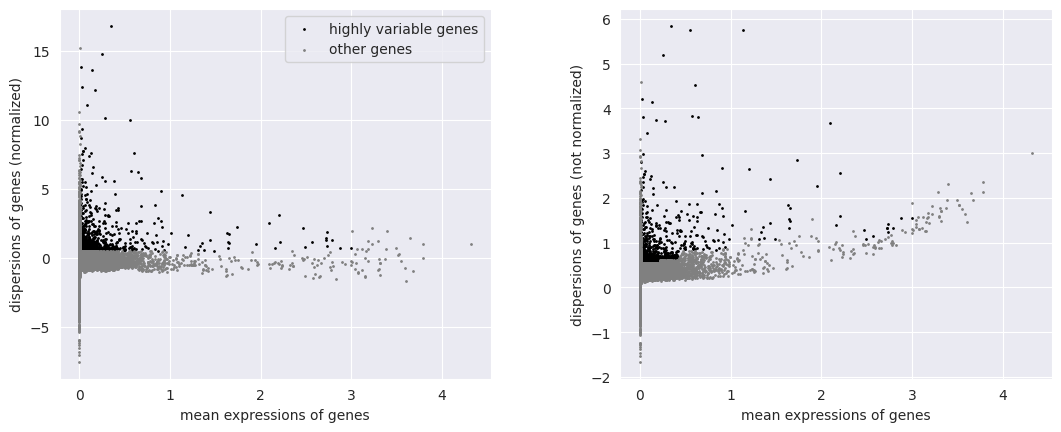

In [62]:
sc.pl.highly_variable_genes(corona_ann)

In [63]:
corona_sub = corona_ann[:, corona_ann.var.highly_variable].copy()

In [64]:
sc.pp.scale(corona_sub, zero_center=True, copy=False)

In [80]:
start = datetime.datetime.now()
sc.pp.neighbors(corona_ann, use_rep="X")
sc.tl.umap(corona_ann)
corona_ann.obsm["X_umap_raw"] = corona_ann.obsm["X_umap"].copy()
print(datetime.datetime.now() - start)

ValueError: cannot assign slice from input of different size

In [ ]:
corona_sub.obsm["X_umap"] = corona_sub.obsm["X_umap_raw"]
sc.pl.umap(corona_sub, components="1,2", color=["cohort", "patientID", "timepoint"])

In [ ]:
sc.tl.pca(corona_sub)
sce.pp.harmony_integrate(corona_sub, ["patientID", "timepoint"])

In [ ]:
start = datetime.datetime.now()
sc.pp.neighbors(corona_sub, use_rep="X_pca_harmony", key_added="neighbors_harmony")
sc.tl.umap(corona_sub, neighbors_key="neighbors_harmony")  # overwrites obsm["X_umap"]
corona_sub.obsm["X_umap_harmony"] = corona_sub.obsm["X_umap"].copy()
print(datetime.datetime.now() - start)
sc.pl.umap(corona_sub, color=["cohort", "patientID", "timepoint"])

In [ ]:
sc.pl.umap(corona_sub, color=["MS4A1", "CD8A", "CD8B", "NKG7"], layer="lognorm_counts")